<a href="https://colab.research.google.com/github/DJLee68/MachineLearningProject/blob/master/Assignment11/DJLee_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

data_path = './MNIST'

train_data = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)
test_data = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


cuda:0





In [2]:
print("the number of your training data (must be 10,000) = ", train_data.__len__())
print("hte number of your testing data (must be 60,000) = ", test_data.__len__())

the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),        
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),            
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1),
        )     

  
    def forward(self,x):
        out = self.layer(x)
        # print('a')
        out = out.view(50, -1)
        # print('b')
        out = self.fc_layer(out)
        # print('c')
        return out

In [4]:
lr=0.01
epochs=100

classification = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification.parameters(), lr=lr)

0.6075903137587011
0.14266996365971862
0.11055185944656841
0.10196380125067663
0.08745562273892574
0.06001699438667856
0.064330874751613
0.0604259640075179
0.06370775598334148
0.06254871234006715


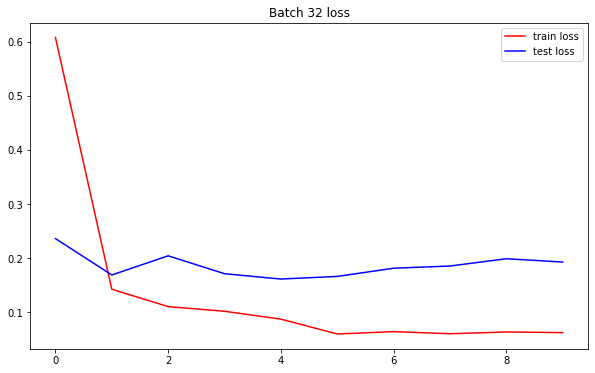

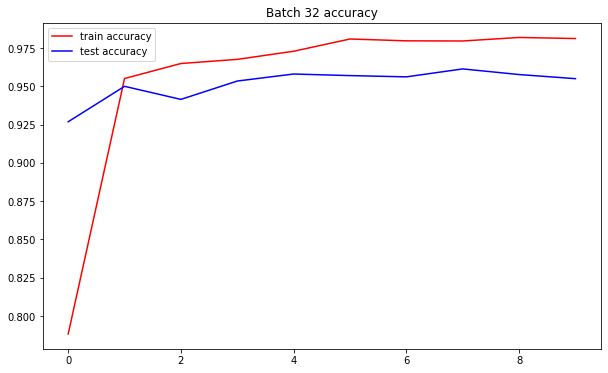

In [5]:
def run_epoch (train_data, test_data):
    
    tr_loss = 0
    tr_acc = 0
    iter = len(train_data)
    classification.train()
    for img_i, label_i in train_data: #{
        img_i, label_i = img_i.to(device), label_i.to(device)

        optimizer.zero_grad()
        # Forward
        y_pred = classification.forward(img_i)
        correct = (label_i == y_pred.max(dim=1)[1])
        # Loss computation
        loss  = criterion(y_pred, label_i)
        # Backward
        loss.backward()
        # Optimize for img_i
        optimizer.step()
        tr_loss += loss.item()
        tr_acc += correct.type(torch.FloatTensor).mean()
    #}
    tr_loss /= iter
    tr_acc /= iter
    print(tr_loss)
    test_loss = 0
    test_acc = 0
    iter_test = len(test_data)

    classification.eval()
    correct = 0
    total = 0
    with torch.autograd.no_grad():
      for img_j, label_j in test_data:
        img_j, label_j = img_j.to(device), label_j.to(device)
        predicted = classification.forward(img_j)
        _, output_idx = torch.max(predicted, 1)
        total += label_j.size(0)
        correct += (output_idx == label_j).sum().float()
        test_loss += criterion(predicted, label_j).item()
    
    test_loss /= iter_test
    test_acc = correct / total
    tr_acc = tr_acc.item()
    test_acc = test_acc.item()
    return tr_loss, tr_acc, test_loss, test_acc


def run(batch_size, epochs): #{
  # global optimizer, criterion, classification
  # classification = CNN().to(device)
  # criterion = nn.CrossEntropyLoss().to(device)
  # optimizer = torch.optim.Adam(classification.parameters(), lr=lr)

  train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)
  
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []

  for epoch in range(epochs): #{
    tr_loss, tr_acc, te_loss, te_acc = run_epoch(train_data_loader, test_data_loader)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    test_loss.append(te_loss)
    test_acc.append(te_acc)
  #}


  return train_loss, test_loss, train_acc, test_acc

#}

train_loss_32, test_loss_32, train_acc_32, test_acc_32 = run(50, epochs)


# Plot image
plt.figure(0, figsize=(10,6))
plt.plot(train_loss_32, label='train loss', c='r')
plt.plot(test_loss_32, label='test loss', c='b')
plt.title(f'Batch 32 loss')
plt.legend()
plt.show()

plt.figure(1, figsize=(10,6))
plt.plot(train_acc_32, label='train accuracy', c='r')
plt.plot(test_acc_32, label='test accuracy', c='b')
plt.title(f'Batch 32 accuracy')
plt.legend()
plt.show()  


## Output using the dataset

 1. Plot the training and testing losses over epochs

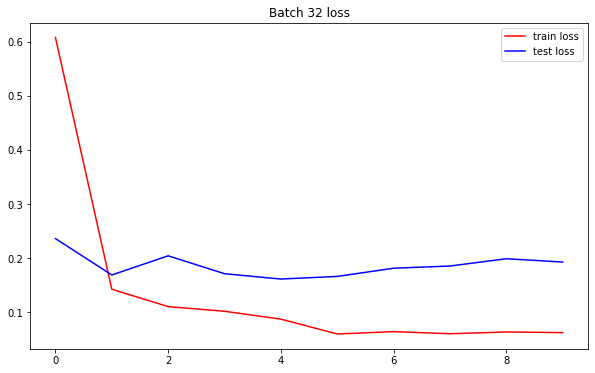

In [7]:
plt.figure(0, figsize=(10,6))
plt.plot(train_loss_32, label='train loss', c='r')
plt.plot(test_loss_32, label='test loss', c='b')
plt.title(f'Batch 32 loss')
plt.legend()
plt.show()

 2. Plot the training and testing accuracies over epochs

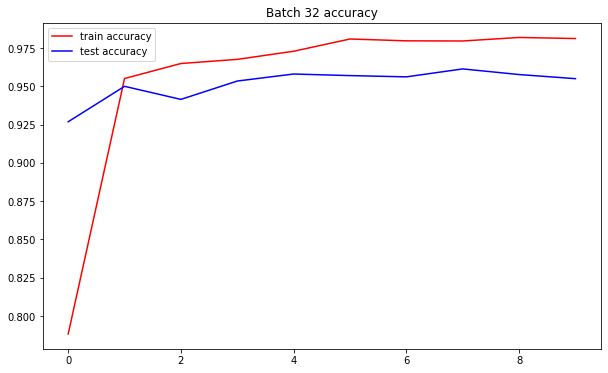

In [8]:
plt.figure(1, figsize=(10,6))
plt.plot(train_acc_32, label='train accuracy', c='r')
plt.plot(test_acc_32, label='test accuracy', c='b')
plt.title(f'Batch 32 accuracy')
plt.legend()
plt.show() 

3. Print the final training and testing losses at convergence

In [9]:
print('Loss')
print(f'training: {round(train_loss_32[-1], 5)}')
print(f'testing: {round(test_loss_32[-1], 5)}')

Loss
training: 0.06255
testing: 0.19285


4. Print the final training and testing accuracies at convergence 

In [10]:
print('Accuracy')
print(f'training: {round(train_acc_32[-1], 5)}')
print(f'testing: {round(test_acc_32[-1], 5)}')

Accuracy
training: 0.9812
testing: 0.955


5. Print the testing accuracies within the last 10 epochs

In [11]:
for i in range(10): #{
  print(f'[epoch = {epochs-9+i}] {round(test_acc_32[-10+i], 5)}')    
#}


[epoch = 1] 0.92687
[epoch = 2] 0.95
[epoch = 3] 0.94147
[epoch = 4] 0.95345
[epoch = 5] 0.95803
[epoch = 6] 0.957
[epoch = 7] 0.95618
[epoch = 8] 0.96137
[epoch = 9] 0.95768
[epoch = 10] 0.955
